In [96]:
import scanpy as sc
import tcri
import pandas as pd
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell
import os
import matplotlib.pyplot as plt
import shutil

In [97]:
adata = sc.read("/Users/ceglian/Data/tcri/zhang/zhang_pp.h5ad")

ct = []
for x,y in zip(adata.obs["timepoint"],adata.obs["patient"]):
    if y == "P13" and x == "post.2":
        ct.append("post.3")
    else:
        ct.append(x)
adata.obs["timepoint"] = ct

ct = []
for x in adata.obs["timepoint"]:
    if "pre" in x:
        ct.append("Pre-treatment")
    else:
        ct.append("Post-treatment")
adata.obs["timepoint_simple"] = ct

ct = []
for x in adata.obs["response"]:
    if "None" in x:
        ct.append("Treatment-Naive")
    else:
        ct.append("On-treatment")
adata.obs["treatment"] = ct


ct = []
for x,y in zip(adata.obs["response"], adata.obs['timepoint']):
    ct.append("{}_{}".format(x,y))
adata.obs["timepoint_complex"] = ct


ct = []
for x,y,z in zip(adata.obs["response"], adata.obs['timepoint'], adata.obs["patient"]):
    ct.append("{}_{}_{}".format(x,y,z))
adata.obs["patient_timepoint_complex"] = ct

ct = []
for x in adata.obs["patient"]:
    if x in ["P13","P01", "P36","P37","P38"]:
        ct.append("NR")
    else:
        ct.append("CR")
adata.obs["complete_response"] = ct

In [98]:
ct = []
for x,y,z in zip(adata.obs["response"], adata.obs['timepoint'], adata.obs["patient"]):
    ct.append("{}_{}_{}".format(x,y,z))
adata.obs["patient_timepoint_complex"] = ct

In [99]:
#any without signed mi were  false
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1.5
mutual_information = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}.p".format(signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
embedding_size     = 100
alpha              = 0.08
beta               = 0.02
gain               = 10
vector_file        = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}_{}_{}_{}_{}.vec".format(embedding_size, alpha, beta, gain, signed_mi, init_ortho)
print(vector_file)
retrain            = True
annotated_h5ad     = "/Users/ceglian/Data/tcri/zhang_annotated.h5ad"
device             = "cpu"
figure_path = "/Users/ceglian/Data/tcri/zhang/figures/"

/Users/ceglian/Data/tcri/zhang_cd8_True_15.p
/Users/ceglian/Data/tcri/zhang_cd8_100_0.08_0.02_10_True_True.vec


In [100]:
genes = [x for x in adata.var.index.tolist()]
genes = [x for x in genes if "TRAV" not in x]
genes = [x for x in genes if "TRAJ" not in x]
genes = [x for x in genes if "TRAD" not in x]


genes = [x for x in genes if "TRBV" not in x]
genes = [x for x in genes if "TRBJ" not in x]
genes = [x for x in genes if "TRBD" not in x]

genes = [x for x in genes if "TRGV" not in x]
genes = [x for x in genes if "TRGJ" not in x]
genes = [x for x in genes if "TRGD" not in x]

genes = [x for x in genes if "TRDV" not in x]
genes = [x for x in genes if "TRDJ" not in x]
genes = [x for x in genes if "TRDD" not in x]

adata = adata[adata.obs["trb"]!=""]
adata = adata[adata.obs["trb"]!="nan"]
adata = adata[adata.obs["trb"]!="Other"]

adata = adata[:,genes]

adata = spell.pp.remove_meaningless_genes(adata)
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
adata.var

100%|██████████| 19264/19264 [00:23<00:00, 807.42it/s]


entropy
ISG15     1.858449
TNFRSF18  2.115975
TNFRSF4   2.379996
ENO1      1.572219
ID3       1.554085
...            ...
GTSE1     1.564562
SAMSN1    1.791777
SOD1      2.123625
MX1       1.500491
S100B     1.834191

[356 rows x 1 columns]

In [101]:
tcri.pp.register_clonotype_key(adata,"trb")

In [102]:
dataset = GeneVectorDataset(adata,load_expression=False,signed_mi=signed_mi,device=device)

Running...
Skipping expression load.


In [103]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
adata

Loading average of 1st and 2nd weights.


100%|██████████| 15252980/15252980 [00:22<00:00, 674162.66it/s]


Generating Cell Vectors.


100%|██████████| 77030/77030 [00:05<00:00, 13223.71it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 77030 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'timepoint_complex', 'patient_timepoint_complex', 'complete_response'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'

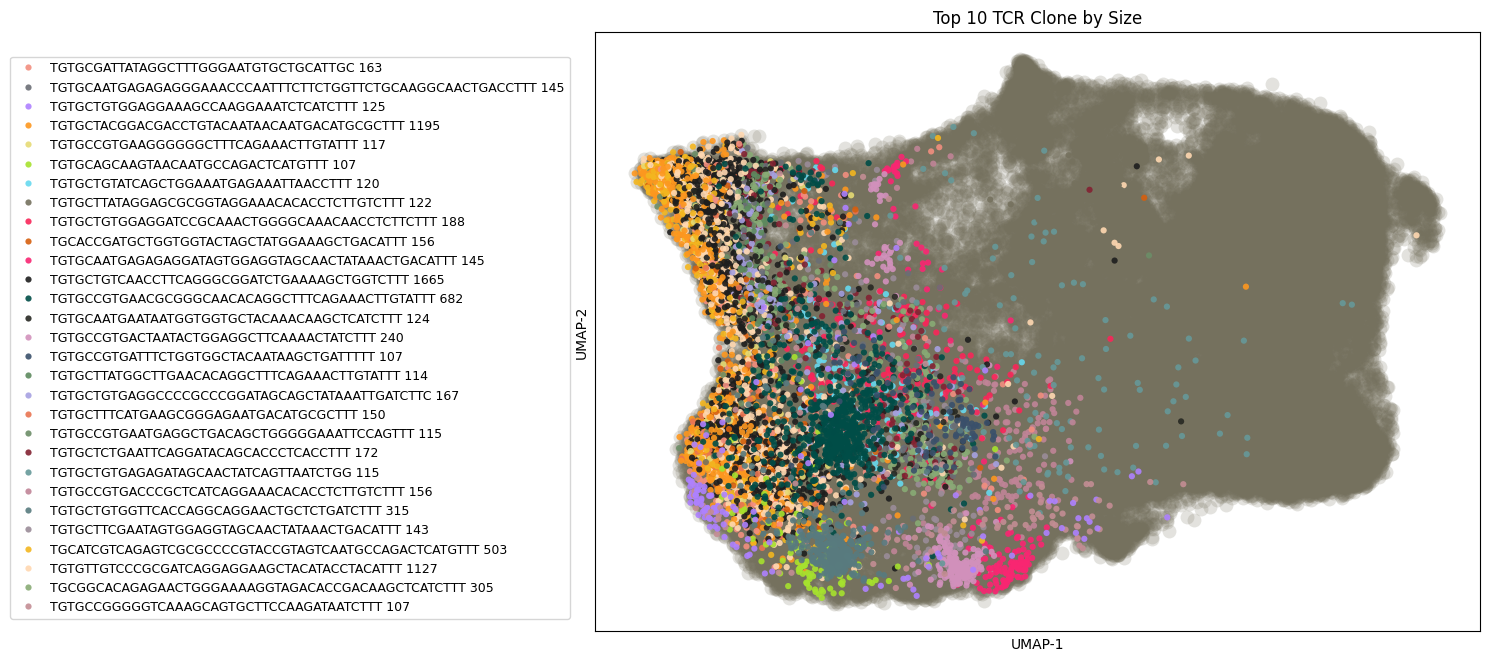

In [104]:
tcri.pl.top_clone_umap(adata, top_n=30, fg_size=20, figsize=(15,7),bg_size=100, bg_alpha=0.2, save="/Users/ceglian/Data/tcri/zhang_clones.pdf")

<Axes: xlabel='UMAP-1', ylabel='UMAP-2'>

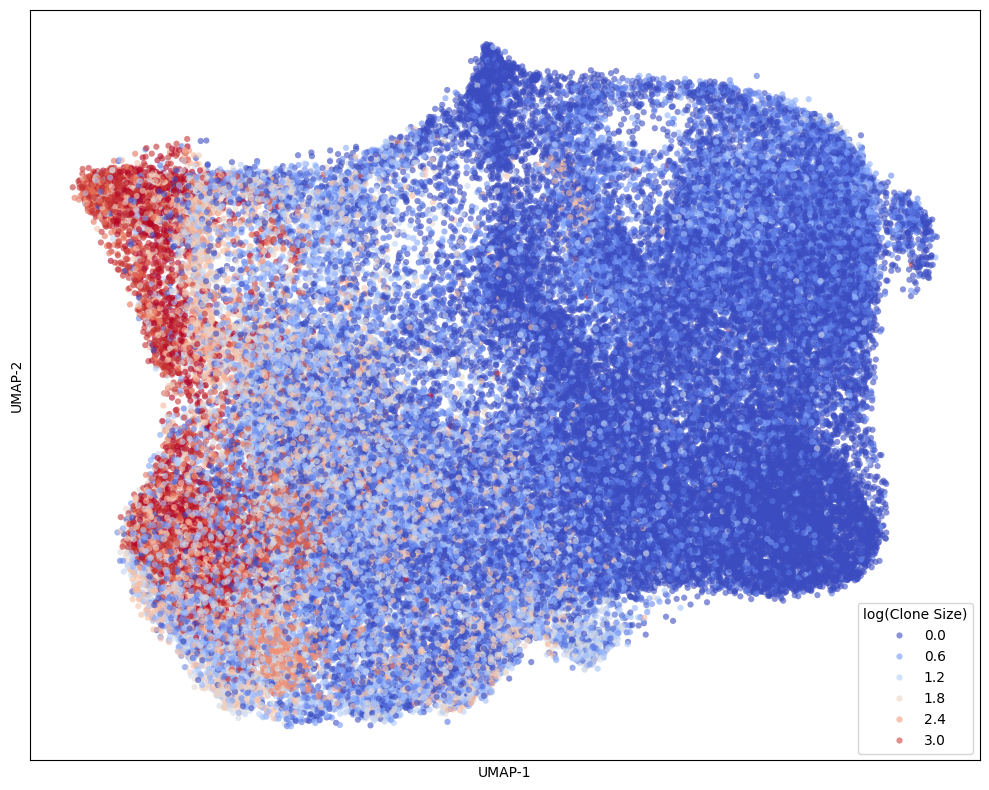

In [105]:
tcri.pl.clone_size_umap(adata,size=20,alpha=0.6,save="/Users/ceglian/Data/tcri/zhang_clone_size.pdf")

In [106]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [107]:
markers = dict()
markers["Naive"] = ["IL7R"]
markers["Memory"] = ["GZMK"]
markers["Activated"] = ["GZMB"]
markers["Dysfunctional"] = ["CXCL13"]
adata, dist = cembed.phenotype_probability(adata, markers, method="normalized_exponential",temperature=0.008, return_distances=True)

Using Normalized Exponential (Temp: 0.008)
Computing similarities for Naive
Markers: IL7R


100%|██████████| 77030/77030 [00:01<00:00, 75309.94it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 77030/77030 [00:01<00:00, 72876.63it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 77030/77030 [00:01<00:00, 73366.79it/s]


Computing similarities for Dysfunctional
Markers: CXCL13


100%|██████████| 77030/77030 [00:01<00:00, 75210.15it/s]


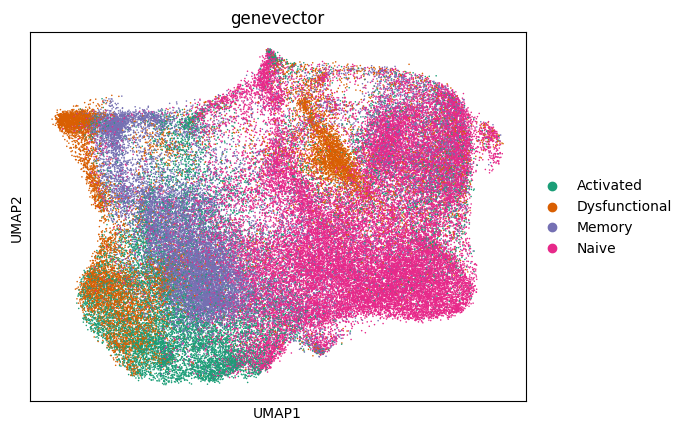

'/Users/ceglian/Data/tcri/zhang/figures/zhang.pdf'

In [108]:
sc.pl.umap(adata,color="genevector",s=5,save="zhang.pdf")
shutil.copyfile("figures/umapzhang.pdf",os.path.join(figure_path,"zhang.pdf"))

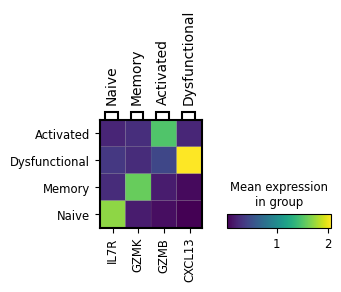

'/Users/ceglian/Data/tcri/zhang/figures/matrixplot_markers.pdf'

In [109]:
sc.pl.matrixplot(adata,markers,groupby="genevector", save="markers.pdf")
shutil.copyfile("figures/matrixplot_markers.pdf",os.path.join(figure_path, "matrixplot_markers.pdf"))

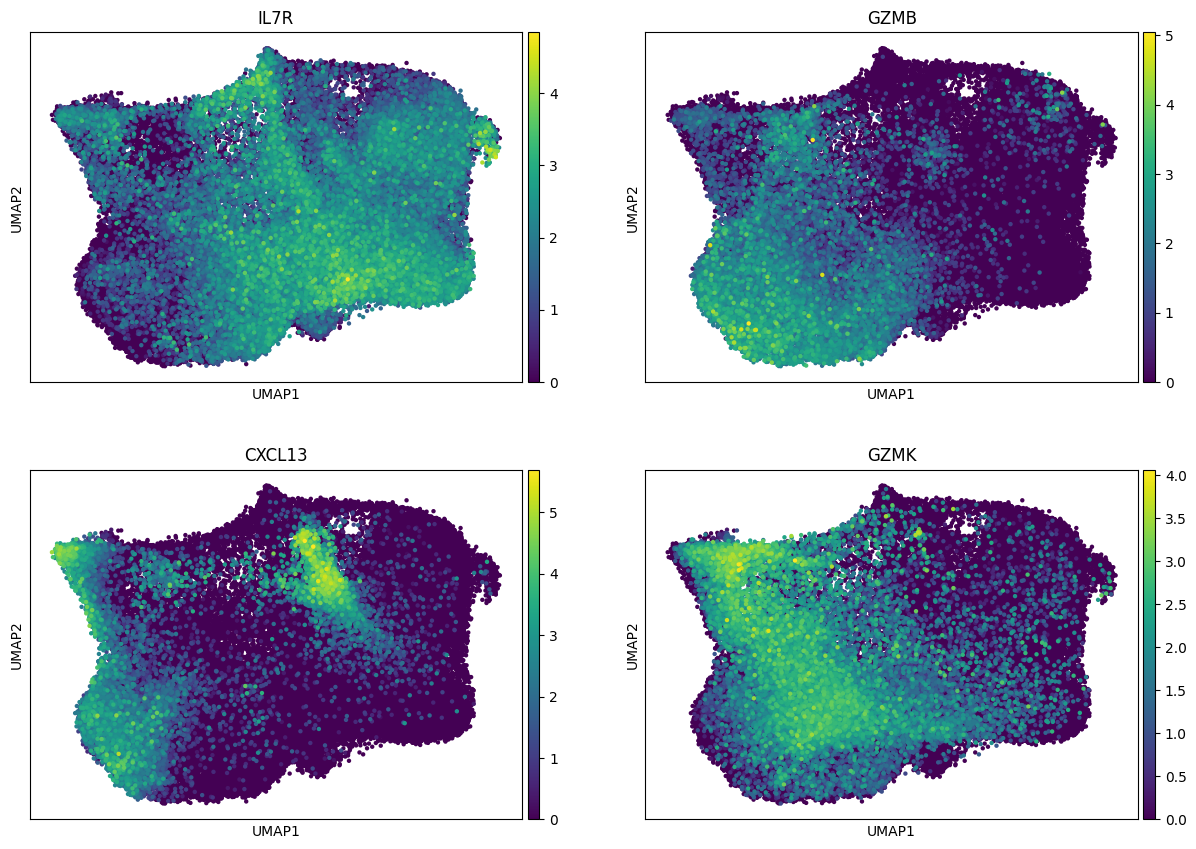

'/Users/ceglian/Data/tcri/zhang/figures/umapzhang_markers.pdf'

In [110]:
sc.pl.umap(adata,color=["IL7R","GZMB","CXCL13","GZMK"],ncols=2,s=40, save="zhang_markers.pdf")
shutil.copyfile("figures/umapzhang_markers.pdf",os.path.join(figure_path, "umapzhang_markers.pdf"))

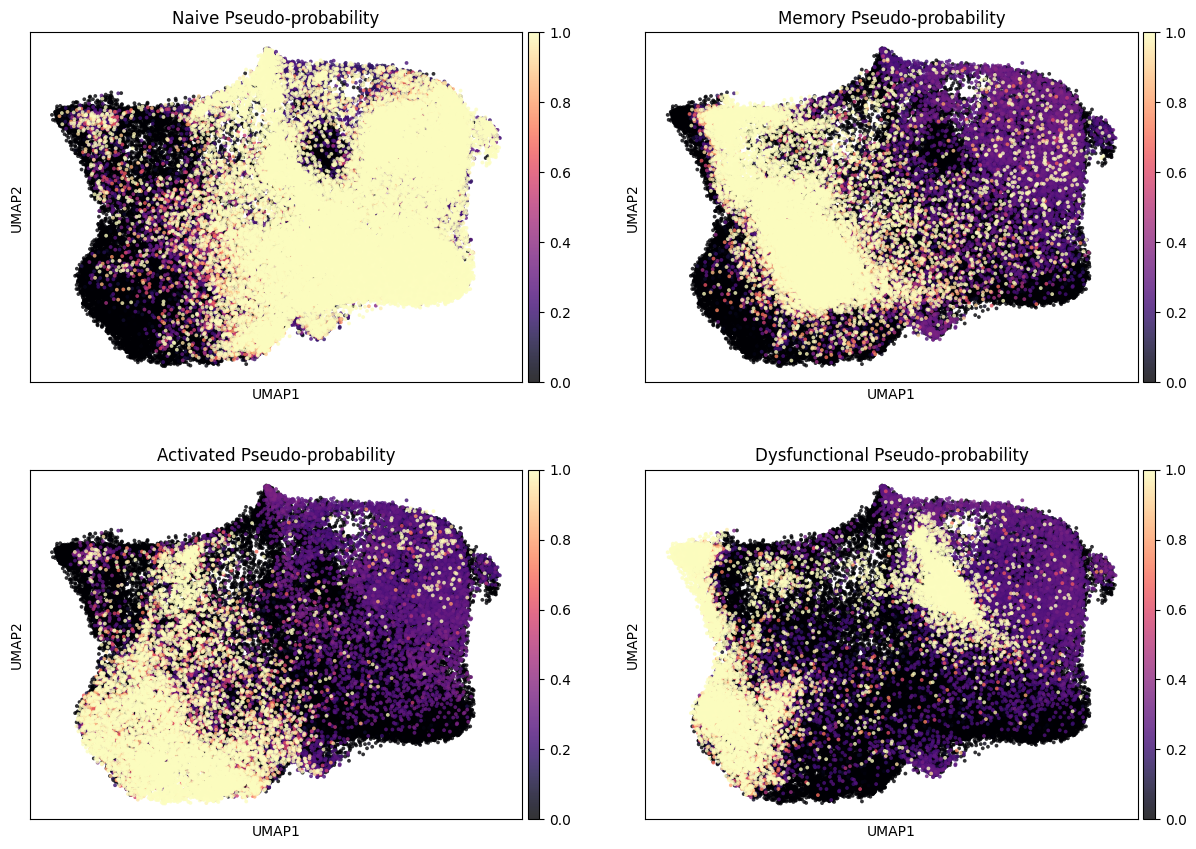

'/Users/ceglian/Data/tcri/zhang/figures/umapprobs.pdf'

In [111]:
cembed.plot_probabilities(adata)
shutil.copyfile("figures/umapprobs.pdf",os.path.join(figure_path,"umapprobs.pdf"))

In [112]:
tcri.pp.clone_size(adata)

In [113]:
tcri.pp.register_phenotype_key(adata,"genevector")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


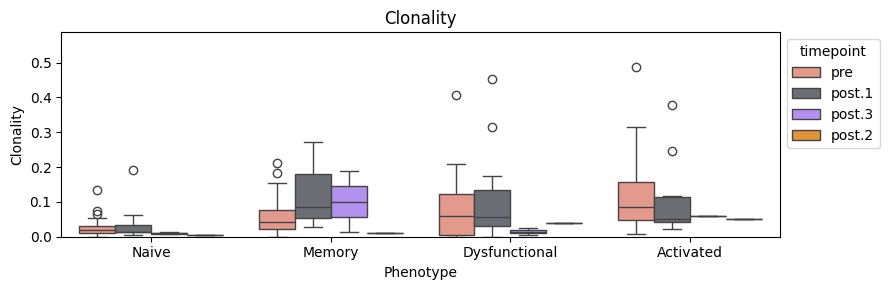

In [114]:
tcri.pl.clonality(adata,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang_clonality.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


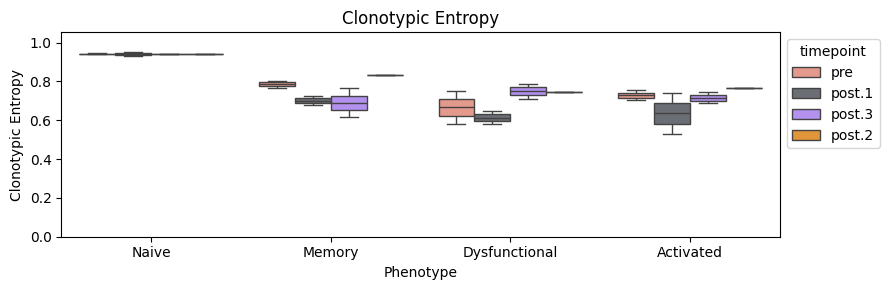

In [115]:
tcri.pl.clonotypic_entropy(adata,groupby="timepoint_complex",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang_clonotypic_entropy.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']
['Naive', 'Memory', 'Dysfunctional', 'Activated']


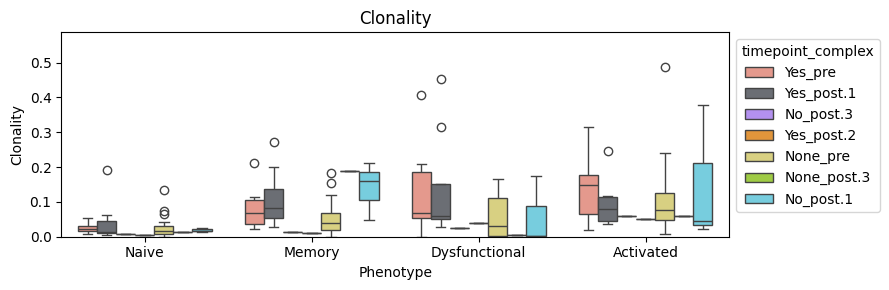

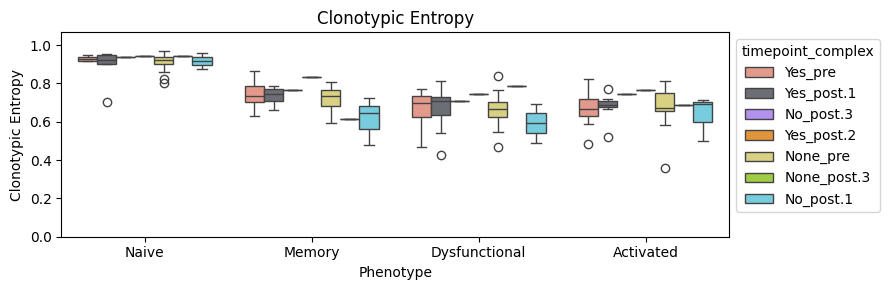

In [116]:
tcri.pl.clonality(adata,groupby="patient_timepoint_complex",figsize=(9,3),splitby="timepoint_complex",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality.pdf")
tcri.pl.clonotypic_entropy(adata,groupby="patient_timepoint_complex",figsize=(9,3),method="probabilistic",splitby="timepoint_complex",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy.pdf")

0.7606326333626282 0.049497553346442236
0.7683634854523053 0.03531083766075671
0.7581359691999897 0.06339480052551316
0.7859325920516106 0.0768247559943348
0.71283567387945 0.043726791783038066
0.6598059486544771 0.17369574833987078
0.6411476162700168 0.17234988231731307
0.677424644598488 0.0386049498291845
0.6478944791134368 0.15074083067066524
0.699267764817814 0.05167670533072932
0.5972837539510107 0.048359614658294525
0.3596003116883934 0.4868899006193941
0.7832911949519888 0.016396911922188062
0.8113950861002488 0.011199304960032408
0.6542454938881649 0.009224445647038948
0.484219725725856 0.3137249516448751
0.5183181650628345 0.24635023965410818
0.6552535363540678 0.05226007938734789
0.6870972458065556 0.0607695105376268
0.7017934190154628 0.07116654779147291
0.704836248991208 0.10957834608839823
0.7677771532642972 0.04818645608519756
0.6673953647025292 0.1298586994454637
0.6738018062238224 0.09695532960249564
0.6481635583155644 0.2100997349560404
0.745237850972545 0.039344844075

Phenotype Patient       Size Timepoint  Clonotypic Entropy  \
0        Activated     P29   7.715049       pre            0.760633   
1        Activated     P29   5.490654    post.1            0.768363   
2        Activated     P17   2.841816       pre            0.758136   
3        Activated      P7   4.107023       pre            0.785933   
4        Activated     P37   3.273810    post.1            0.712836   
..             ...     ...        ...       ...                 ...   
179  Dysfunctional     P35  15.572127    post.1            0.710361   
180  Dysfunctional      P5   4.069767       pre            0.465823   
181  Dysfunctional     P11   8.222314       pre            0.609754   
182  Dysfunctional      P6   6.138961       pre            0.697953   
183  Dysfunctional     P26   4.555556       pre            0.547735   

     Clonality  Dysfunction  Number Phenotypes  
0     0.049498     0.215436                  4  
1     0.035311     0.189294                  4  
2     0.063395     0.259620                  4  
3     0.076825     0.501148                  4  
4     0.043727     0.307915                  4  
..         ...          ...                ...  
179   0.057805     0.132686                  4  
180   0.166062     0.371237                  4  
181   0.121447     0.226294                  4  
182   0.011160     0.173309                  4  
183   0.000000     0.168169                  4  

[184 rows x 8 columns]

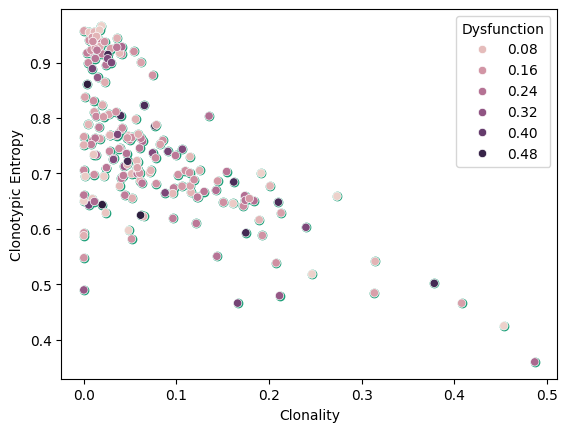

In [117]:
x = []
y = []

phs = []
tps = []
pt = []

sz = []
dys = []
nphenos = []

import numpy as np

for ph in set(adata.obs['genevector']):
    for p in set(adata.obs["patient"]):
        sub = adata[adata.obs["patient"] == p]
        for tp in set(sub.obs["timepoint"]):
            subx = sub[sub.obs["timepoint"] == tp]
            cent = tcri.tl.clonotypic_entropy(subx,ph,normalized=True)
            clonality = tcri.tl.clonality(subx)[ph]
            dys.append(np.mean(subx.obs['Activated Pseudo-probability']))
            sz.append(np.mean(subx.obs['clone_size']))
            nphenos.append(len(set(subx.obs["genevector"])))
            phs.append(ph)
            pt.append(p)
            tps.append(tp)
            x.append(cent)                            
            y.append(clonality)
            print(cent,clonality)
plt.scatter(y,x)
plt.ylabel("Clonotypic Entropy")
plt.xlabel("Clonality")

import seaborn as sns

df = pd.DataFrame.from_dict({"Phenotype":phs,"Patient":pt,"Size":sz, "Timepoint":tps, "Clonotypic Entropy": x, "Clonality": y, "Dysfunction": dys, "Number Phenotypes": nphenos})
# df["Size"] = np.log2(df["Size"])
sns.scatterplot(data=df, x= "Clonality",y="Clonotypic Entropy", hue="Dysfunction")
df

In [118]:
import collections

dfx = df[df['Clonality'] <= 0.0]
dfx = dfx[dfx["Clonotypic Entropy"] < 0.8]
dfx
# vclones = []
# valid = collections.defaultdict(list)
# for pt,tp in zip(dfx["Patient"], dfx['Timepoint']):
#     valid[pt].append(tp)

# for pt, tps in valid.items():
#     sdata = adata[adata.obs["patient"] == pt]
#     fdata = sdata[sdata.obs["timepoint"].isin(tps)]
#     fdata = fdata[fdata.obs["genevector"] == "Dysfunctional"]


Phenotype Patient       Size Timepoint  Clonotypic Entropy  \
137         Memory     P26   4.555556       pre            0.592644   
142  Dysfunctional     P37   3.273810    post.1            0.489627   
148  Dysfunctional     P20   3.963636       pre            0.650270   
155  Dysfunctional     P23   7.362003       pre            0.587680   
157  Dysfunctional     P13  10.185358       pre            0.751445   
160  Dysfunctional     P15   5.717277       pre            0.660913   
163  Dysfunctional     P21   5.542353       pre            0.705733   
173  Dysfunctional     P16   4.852772       pre            0.766389   
183  Dysfunctional     P26   4.555556       pre            0.547735   

     Clonality  Dysfunction  Number Phenotypes  
137        0.0     0.168169                  4  
142        0.0     0.307915                  4  
148        0.0     0.040399                  4  
155        0.0     0.107463                  4  
157        0.0     0.102617                  4  
160        0.0     0.229498                  4  
163        0.0     0.189905                  4  
173        0.0     0.140530                  4  
183        0.0     0.168169                  4

In [94]:
tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy.pdf")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/38/rslqw81d2rx5jfmt2pc_dmnhd336fz/T/ipykernel_45799/2004676195.py", line 1, in <module>
    tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
  File "/Users/ceglian/GitHub/tcri/tcri/plotting/_plotting.py", line 428, in clonotypic_entropy
  File "/Users/ceglian/GitHub/tcri/tcri/plotting/_plotting.py", line 401, in tcri_boxplot
    df = pd.DataFrame(list(data.items()), columns=['Phenotype', ylabel])
  File "/Users/ceglian/GitHub/tcri/tcri/plotting/_plotting.py", line 427, in <lambda>
    return tcri_boxplot(adata, func, groupby=groupby, ylabel="Clonotypic Entropy", splitby=splitby, s=s, figsize=figsize, order=order)
  File "/

['Naive', 'Memory', 'Dysfunctional', 'Activated']


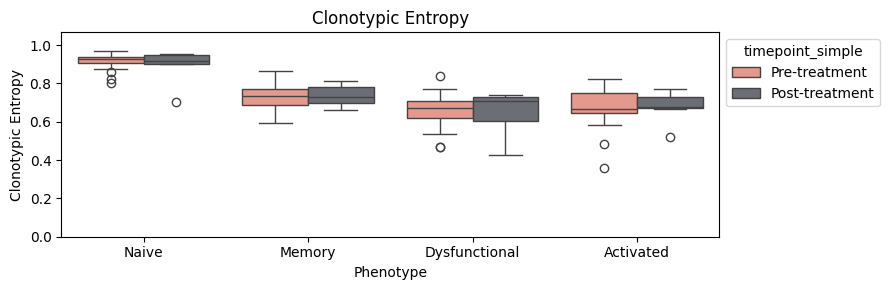

In [120]:
sub = adata[adata.obs["complete_response"] == "CR"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint_simple",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


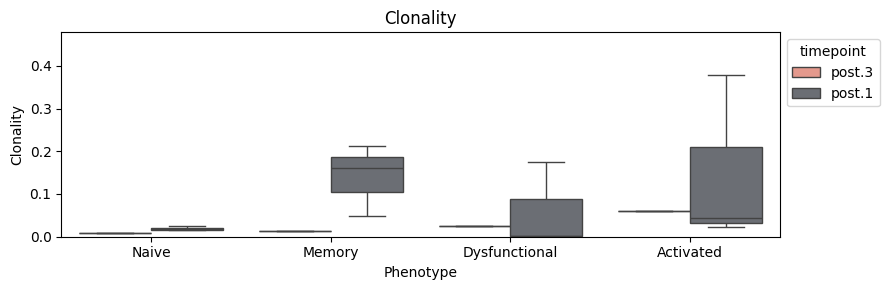

In [29]:
sub = adata[adata.obs["response"] == "No"]
tcri.pl.clonality(sub,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality.pdf")

['Dysfunctional', 'Memory', 'Activated', 'Naive']
['Activated', 'Dysfunctional', 'Memory', 'Naive']


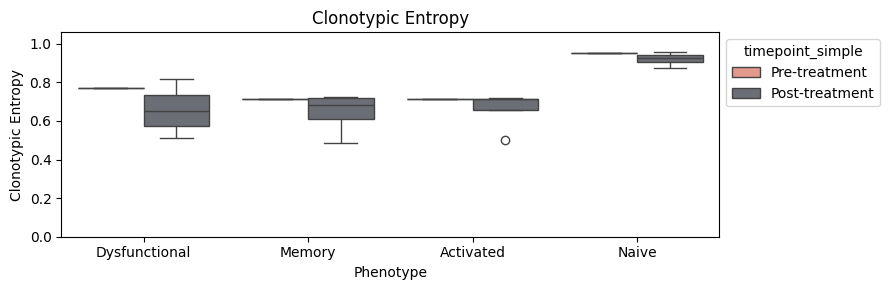

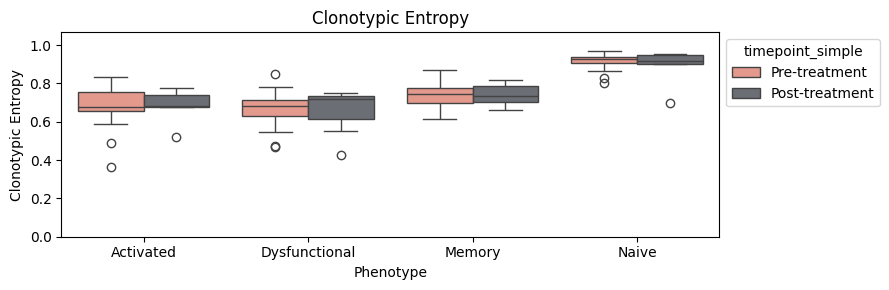

In [47]:
sub = adata[adata.obs["complete_response"] == "NR"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint_simple",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy_no.pdf")


sub = adata[adata.obs["complete_response"] == "CR"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint_simple",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy_no.pdf")


['Naive', 'Memory', 'Dysfunctional', 'Activated']


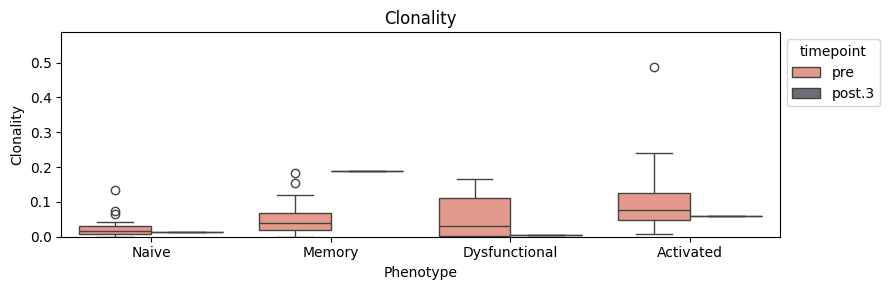

In [31]:
sub = adata[adata.obs["response"] == "None"]
tcri.pl.clonality(sub,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality_tx_naive.pdf")

['Activated', 'Dysfunctional', 'Memory', 'Naive']


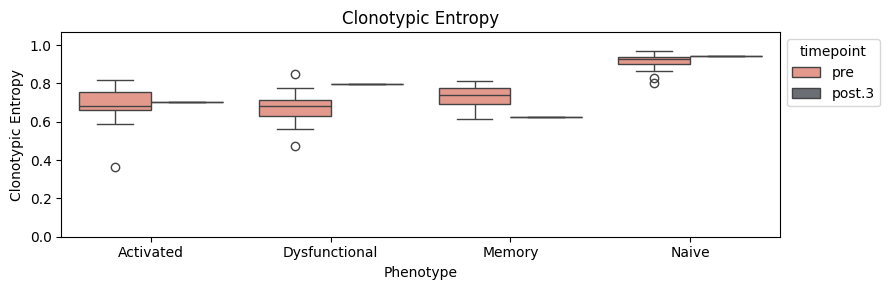

In [39]:
sub = adata[adata.obs["response"] == "None"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy_none.pdf")

View of AnnData object with n_obs × n_vars = 50717 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment', 'Size', 'TCR Sequence', 'clone_size', 'UMAP1', 'UMAP2', 'log(Clone Size)', 'genevector', 'Naive Pseudo-probability', 'Memory Pseudo-probability', 'Activated Pseudo-probability', 'Dysfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'log1p', 'probability_columns', 'genevector_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'joint_distribution'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'
['Activated', 'Dysfunctional', 'Memory', 'Naive']


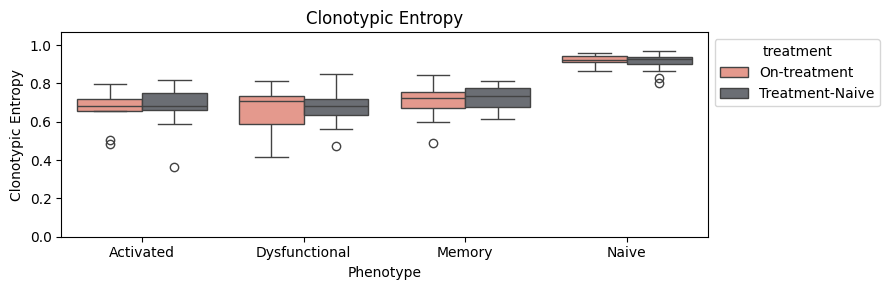

In [40]:
sub = adata[adata.obs["treatment"] == "On-treatment"]
sub = sub[sub.obs[""]]
print(sub)
tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(9,3),method="probabilistic",splitby="treatment",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy_none.pdf")

In [1]:
tcri.tl.phenotypic_entropies(adata)

NameError: name 'tcri' is not defined

In [85]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from statannot import add_stat_annotation
# import matplotlib.patches as mpatches

# from gseapy import dotplot
# import tqdm

# import collections
# import operator
# import itertools


# def flux(adata, key, order, groupby, method="probabilistic", paint=None, distance_metric="l1", figsize=(12,5)):
#     dfs = []
#     if paint != None:
#         palette = []
#         legend_handles = [] 
#         paint_categories = adata.obs[paint].unique()
#         pcolors = dict(zip(paint_categories, tcri.pl.tcri_colors))
#         for category in paint_categories:
#             handle = mpatches.Patch(color=pcolors[category], label=category)
#             legend_handles.append(handle)
#     else:
#         palette = tcri.pl.tcri_colors
#     for x in tqdm.tqdm(list(set(adata.obs[groupby]))):
#         sdata = adata[adata.obs[groupby]==x]
#         hue_order = []
#         for i in range(len(order)-1):
#             l1_distances = tcri.tl.flux(sdata,key=key,from_this=order[i],to_that=order[i+1],distance_metric=distance_metric)
#             df = pd.DataFrame(list(l1_distances.items()), columns=['Clone', distance_metric])
#             df[groupby] = x
#             if paint!=None:
#                 pcat = sdata.obs[paint].unique().tolist()[0]
#                 palette.append(pcolors[pcat])
#             df["Comparison"] = "{}_{}".format(order[i],order[i+1])
#             hue_order.append("{}_{}".format(order[i],order[i+1]))
#             dfs.append(df)
#     df = pd.concat(dfs)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.dropna(inplace=True)
#     order = df.groupby(groupby).median(distance_metric).sort_values(distance_metric).index.tolist()
#     fig,ax=plt.subplots(1,1,figsize=figsize)
#     sns.boxplot(data=df,x=groupby,y=distance_metric,hue="Comparison",order=order,palette=palette,ax=ax, hue_order=hue_order)
#     if paint != None:
#         ax.legend(handles=legend_handles, title=paint)
#     fig.tight_layout()
#     return ax

sub = adata[adata.obs["clone_size"]>20]
tcri.pl.flux(sub, key="timepoint", order=["pre","post.1","post.2","post.3"], groupby="patient", method="probabilistic", distance_metric="dkl",figsize=(10,4))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/flux_l1.pdf",)

NameError: name 'tcri' is not defined

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools
from tcri.pl import tcri_colors
from tcri.tl import clonotypic_entropies as centropies
from tcri.tl import clonality as clonality_tl
from tcri.tl import flux as flux_tl
from tcri.tl import mutual_information as mutual_information_tl
from tcri.tl import clone_fraction as clone_fraction_tl
from tcri.ut     import Phenotypes, CellRepertoire, Tcell, plot_pheno_sankey, plot_pheno_ternary_change_plots, draw_clone_bars
from tcri.pl import clone_size, joint_distribution

def phenotypic_flux(adata, splitby, order, clones=None, normalize=True, nt=True, phenotype_colors=None):
    phenotypes = Phenotypes(adata.obs[adata.uns["tcri_phenotype_key"]].unique())
    repertoires = dict()
    times = list(range(len(order)))
    for s in order:
        repertoires[s] = CellRepertoire(clones_and_phenos = {}, 
                                        phenotypes = phenotypes, 
                                        use_genes = False, 
                                        use_chain = False,
                                        seq_type = 'ntseq',
                                        chains_to_use = ['TRB'],
                                        name = s)
    for condition, seq, phenotype in zip(adata.obs[splitby],
                                         adata.obs[adata.uns["tcri_clone_key"]],
                                         adata.obs[adata.uns["tcri_phenotype_key"]]):
        if str(seq) != "nan" and condition in repertoires:
            if nt:
                t = Tcell(phenotypes = phenotypes, phenotypes_and_counts = {phenotype: 1}, 
                                                          TRB = dict(ntseq = seq), 
                                                          use_genes = False)
            else:
                t = Tcell(phenotypes = phenotypes, phenotypes_and_counts = {phenotype: 1}, 
                                                          TRB = dict(aaseq = seq), 
                                                          use_genes = False)
            repertoires[condition].cell_list.append(t)
    for condition, rep in repertoires.items():
        rep._set_consistency()
    if phenotype_colors==None:
        phenotype_colors = dict(zip(set(adata.obs[adata.uns["tcri_phenotype_key"]]), tcri_colors))
    fig, ax = plot_pheno_sankey(phenotypes = phenotypes, 
                                cell_repertoires = [repertoires[condition] for condition in order], 
                                clones = clones,
                                times = times,
                                xlim = [min(times), max(times)],
                                time_rescale = 1,
                                normalize=normalize,
                                xlabel = splitby,
                                return_axes = True, 
                                show_legend = True,
                                phenotype_colors=phenotype_colors)
    ax.set_xticks(times)
    ax.set_xticklabels(order)

In [57]:
phenotype_colors = dict(zip(set(adata.obs[adata.uns["tcri_phenotype_key"]]), tcri_colors[5:]))

In [192]:
sub[sub.obs["response"] == "No"].obs["timepoint"]


tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=False,phenotype_colors=phenotype_colors, figsize=(12,5))

Series([], Name: timepoint, dtype: category
Categories (0, object): [])

{'No', 'Yes'}
     timepoint                          Category         Value
0          pre          Naive Pseudo-probability  9.170366e-01
1          pre          Naive Pseudo-probability  6.084863e-03
2          pre          Naive Pseudo-probability  1.389751e-12
3          pre          Naive Pseudo-probability  2.279031e-06
4          pre          Naive Pseudo-probability  3.555142e-03
...        ...                               ...           ...
2155    post.2  Dysfunctional Pseudo-probability  4.368297e-01
2156    post.2  Dysfunctional Pseudo-probability  3.436101e-01
2157    post.2  Dysfunctional Pseudo-probability  1.714172e-04
2158    post.2  Dysfunctional Pseudo-probability  4.442400e-06
2159    post.2  Dysfunctional Pseudo-probability  3.659333e-01

[2160 rows x 3 columns]


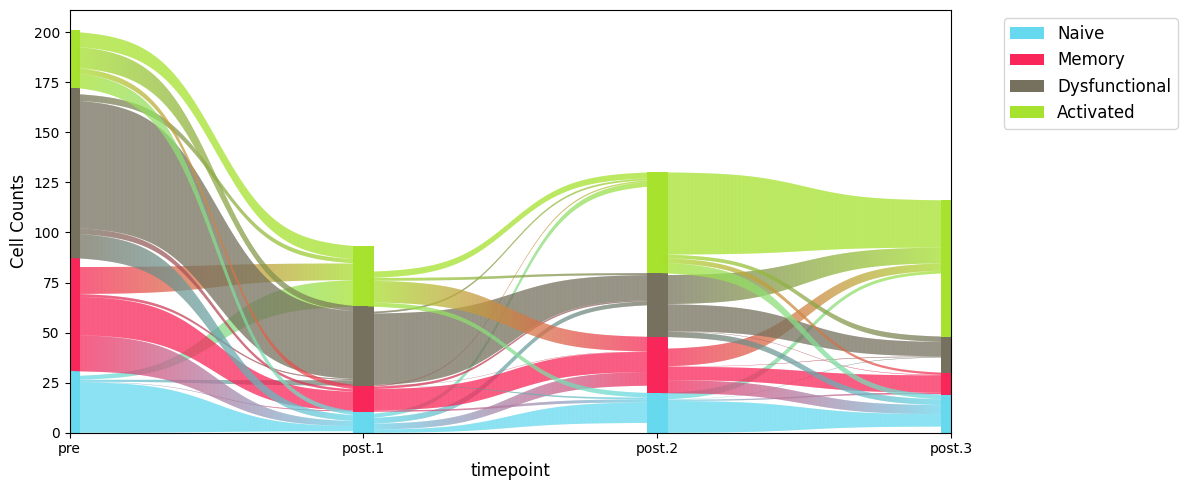

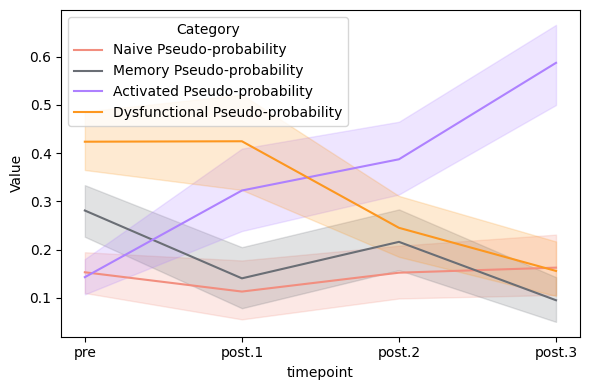

In [105]:
sub = adata[adata.obs["patient"] == "P1"]
sub = sub[sub.obs["clone_size"]>15]
print(set(sub.obs["response"]))
tcri.pp.joint_distribution(sub)

plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p1_sankey.pdf")

df = sub.obs[["timepoint"]+sub.uns["probability_columns"]]
order=["pre","post.1","post.2","post.3"]
df['timepoint'] = pd.Categorical(df['timepoint'], categories=order, ordered=True)
df_long = df.melt(id_vars='timepoint', var_name='Category', value_name='Value')
print(df_long)
fig,ax=plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data=df_long,x="timepoint",y="Value",hue="Category",ax=ax)
fig.tight_layout()

{'None', 'Yes'}
     timepoint                          Category         Value
0          pre          Naive Pseudo-probability  2.510302e-04
1          pre          Naive Pseudo-probability  3.999363e-03
2          pre          Naive Pseudo-probability  9.995544e-01
3          pre          Naive Pseudo-probability  2.235872e-04
4          pre          Naive Pseudo-probability  6.928853e-02
...        ...                               ...           ...
2931    post.2  Dysfunctional Pseudo-probability  6.078470e-06
2932    post.2  Dysfunctional Pseudo-probability  9.437256e-05
2933    post.2  Dysfunctional Pseudo-probability  2.011575e-08
2934    post.2  Dysfunctional Pseudo-probability  3.953970e-03
2935    post.2  Dysfunctional Pseudo-probability  1.054158e-03

[2936 rows x 3 columns]


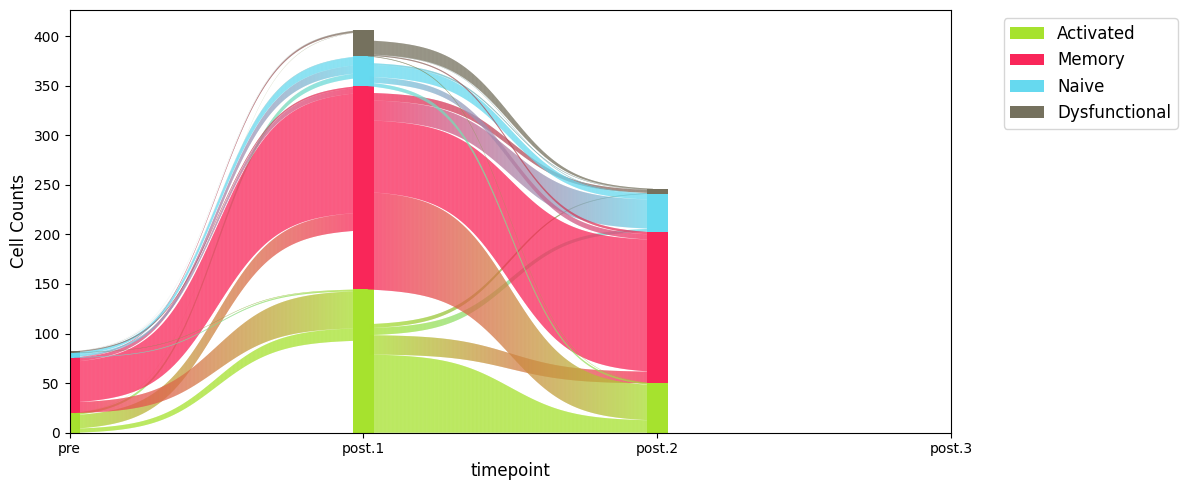

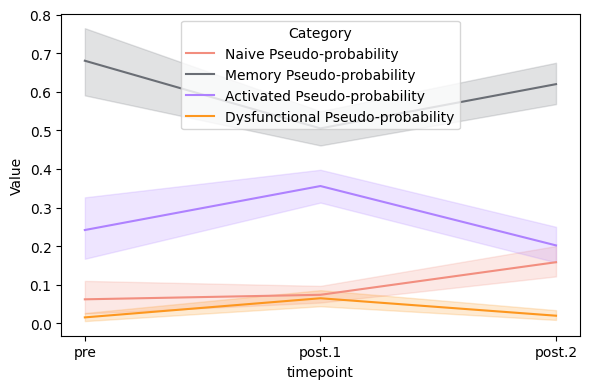

In [190]:
sub = adata[adata.obs["patient"] == "P13"]
sub = sub[sub.obs["clone_size"]>15]
print(set(sub.obs["response"]))
tcri.pp.joint_distribution(sub)
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=False,phenotype_colors=phenotype_colors,figsize=(12,5))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p13_sankey.pdf")

df = sub.obs[["timepoint"]+sub.uns["probability_columns"]]
order=["pre","post.1","post.2","post.3"]
df['timepoint'] = pd.Categorical(df['timepoint'], categories=order, ordered=True)
df_long = df.melt(id_vars='timepoint', var_name='Category', value_name='Value')
print(df_long)
fig,ax=plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data=df_long,x="timepoint",y="Value",hue="Category",ax=ax,color=color)
fig.tight_layout()


In [188]:
pcolors = dict()
color = []
for x,y in phenotype_colors.items():
    pcolors[x + " Pseudo-probability"] = y
    color.append(y)


100%|██████████| 2/2 [00:00<00:00, 15.54it/s]


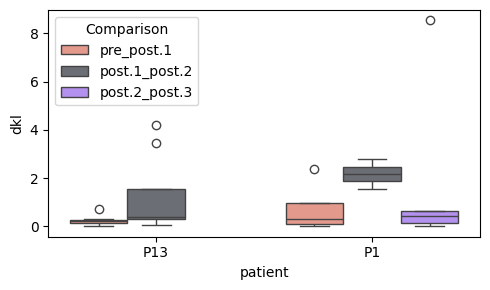

In [111]:
sub = adata[adata.obs["patient"].isin(["P13","P1"])]
sub = sub[sub.obs["clone_size"]>25]
flux(sub, key="timepoint", order=["pre","post.1","post.2","post.3"], groupby="patient", method="probabilistic", distance_metric="dkl",figsize=(5,3))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/dkl_response.pdf")

[0.06400288922510547, 0.044595969126105736, 0.0028296081044968386]
[0.031779612472209645, 2.9757910977562113e-08, 0.1432338402674869]
[0.19047198928689463, 0.002147254097033246, 0.5565255947561026]
[0.047234939116192094, 4.7008682471520846e-05, 3.431211988893942e-05]
[0.017826231782828494, 0.3561783162529715, 0.0005273194711973634]
[0.14263680266912201, 0.24913461781832968, 0.0023625857471987768]
[0.00015406186089429754, 0.0008955378143748926, 6.148077340904669e-05]
[0.11325953836287482, 0.12456775715199218, 0.002399037676957097]
[0.45421774306301, 0.544519784372874, 0.5232998033999713]
[0.010061855465647106, 2.4839988973764265e-05, 0.0008039700646222547]
[0.9897975962366747, 0.2897947540267636, 0.9917763662062324]
[0.08333111718676801, 0.6140986412193328, 0.4966912723131503]
[0.07953623414411937, 0.10579422933857226, 2.369568537862593e-06]
[0.001975253509081101, 0.0004484055220478803, 0.00028922828406208493]
[0.19453583762462967, 0.11947106991166463, 0.00034006496614911444]
[8.1108833

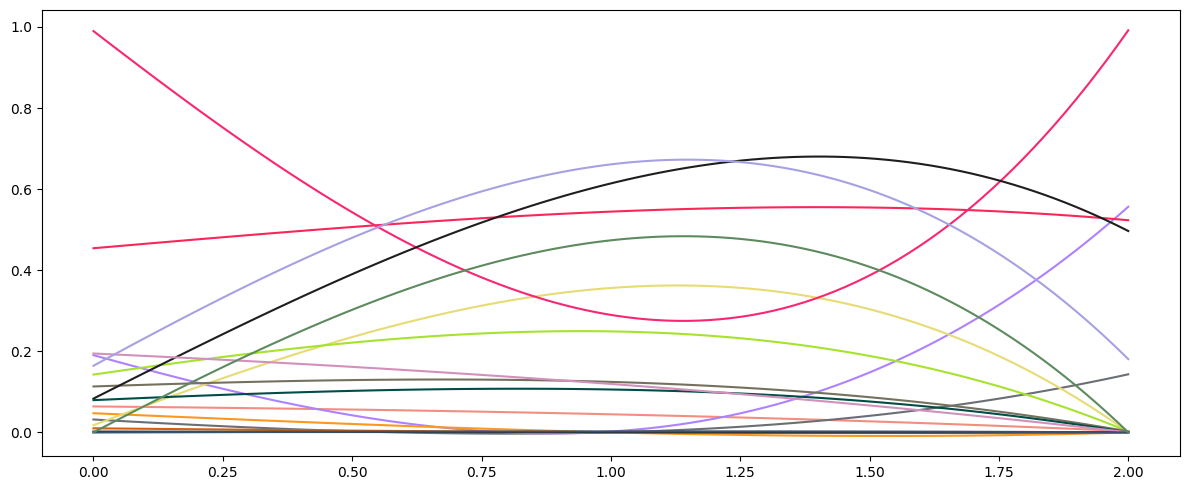

In [183]:
tcri.pl.clonality(adata,)

In [165]:
series

[0.06400288922510547, 0.044595969126105736, 0.0028296081044968386]

In [166]:
xs

[0, 0, 0]